* `nwem_files`: A pattern matching each Matlab file of raw data from the NWEM FTP site
* `nwem_stations`: This structure is copy-pasted from a JS file loaded for the map on https://nwem.apl.washington.edu/prod_PugetSound.shtml, then IDs were manually inserted to match the location prefixes on the Matlab file names

In [1]:
nwem_files = "data/NWEM/*.mat"
nwem_stations = [
    ['HC_TW','<div class="map-window"><h5>Twanoh</h5><img src="http://orcabase.ocean.washington.edu/lynchcove_orca.png"><br>47.375 N, -123.0083 W<br>35 meters depth<br><a href="prod_PS_Twanoh.shtml">&raquo; view data</a></div>', 47.375, -123.0083 , 'Twanoh'],
    ['HC_HP','<div class="map-window"><h5>Hoodsport</h5><img src="http://orcabase.ocean.washington.edu/hoodsport_orca.jpg"><br>47.4218 N, -123.1126 W<br>120 meters depth<br><a href="prod_PS_Hoodsport.shtml">&raquo; view data</a></div>', 47.4218, -123.1126, 'Hoodsport'],
    ['HC_DB','<div class="map-window"><h5>Dabob Bay</h5><img src="http://orcabase.ocean.washington.edu/lynchcove_orca.png"><br>47.8034 N, -122.8029 W<br>100 meters depth<br><a href="prod_PS_Dabob.shtml">&raquo; view data</a></div>', 47.8034, -122.8029, 'Dabob Bay'],
    ['HC_NB','<div class="map-window"><h5>Hansville</h5><img src="http://orcabase.ocean.washington.edu/northbuoy_orca.png"><br>47.907 N, -122.627 W<br>100 meters depth<br><a href="prod_PS_NorthB.shtml">&raquo; view data</a></div>', 47.907, -122.627, 'Hansville'],
    ['PW','<div class="map-window"><h5>Point Wells</h5><img src="http://orcabase.ocean.washington.edu/northbuoy_orca.png"><br>47.761 N, -122.3972 W<br>100 meters depth<br><a href="prod_PS_PWells.shtml">&raquo; view data</a></div>', 47.761167, -122.397167, 'Point Wells'],
    ['CI','<div class="map-window"><h5>Carr Inlet</h5><img src="http://orcabase.ocean.washington.edu/northbuoy_orca.png"><br>47.28 N, -122.728 W<br>47 meters depth<br><a href="prod_PS_Carr.shtml">&raquo; view data</a></div>', 47.27965, -122.72763, 'Carr Inlet']
]
# I don't know where to get the ChaBa data at this time
#    [,'<div class="map-window"><h5>NEMO - Ćháʔba·</h5>47&deg; 57.997\' N, 124&deg; 56.987\' W<br>100 meters depth<br><a href="prod_CS_ChaBa.shtml">&raquo; view data</a></div>', 47.9666167, -124.9497833, 'ChaBa'],
# Bellingham Bay data is in a different format on the data portal that I haven't parsed yet
#    ['<div class="map-window"><h5>NEMO - Sub-Surface/ESP</h5>47&deg; 58\' N, 124&deg; 57\' W<br>100 meters depth<br><a href="prod_CS_SubSurface.shtml">&raquo; view data</a></div>', 47.9766667, -124.9500000, 'SubSurf'],
#    ['<div class="map-window"><h5>Bellingham Bay</h5>48&deg; N, 122&deg; W<br>100 meters depth<br><a href="prod_BB_BellBay.shtml">&raquo; view data</a></div>', 48.737601, -122.563964, 'BellBay']

# These data files have not been processed to remove bad data. These parameters
# control some simple filtering to clean up
# Threshold values for peak-finding algorithm
outlier_thresholds = {
    'temp': 2,
    'salt': 2,
    'o2': 3,
    'chla': 50
}
# After peak outliers have been removed, any values outside the given ranges for a
# parameter will cause the entire cast to be dropped for that parameter
limits = {
    'temp': (-5, 30),
    'salt': (None, 40),
    'o2': (0, 20)
}

import glob
import json
import uuid
import os
from scipy.io import loadmat
from scipy.signal import find_peaks
from multiprocessing import Pool
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import db

In [2]:
station_df = pd.DataFrame(nwem_stations, columns=('name','html','lat','lon','description')).drop(columns='html')
station_df['description'] += ' ORCA Buoy'
# Make a GeoDataFrame for the stations
station_gdf = gpd.GeoDataFrame(
    station_df.drop(['lat','lon'],axis=1),
    crs='epsg:6318',
    geometry=[Point(xy) for xy in zip(station_df.lon, station_df.lat)]
).rename_geometry('geom').set_index('name').to_crs(epsg=32610)
station_gdf

,description,geom
name,,
HC_TW,Twanoh ORCA Buoy,POINT (499373.416 5246837.904)
HC_HP,Hoodsport ORCA Buoy,POINT (491507.124 5252045.093)
HC_DB,Dabob Bay ORCA Buoy,POINT (514758.545 5294468.133)
HC_NB,Hansville ORCA Buoy,POINT (527874.074 5306031.073)
PW,Point Wells ORCA Buoy,POINT (545175.714 5289931.435)
CI,Carr Inlet ORCA Buoy,POINT (520598.789 5236277.333)


In [3]:
engine = db.connect()
locations_existing = gpd.read_postgis('SELECT * FROM obsdata.stations', con=engine, index_col='name')
station_gdf = station_gdf.loc[~station_gdf.index.isin(locations_existing.index)]
if len(station_gdf) > 0:
    station_gdf.to_postgis('stations', con=engine, schema='obsdata', index=True, index_label='name', if_exists='append')
    print(f'Loaded {len(station_gdf)} locations')

    station_gdf = gpd.read_postgis('SELECT * FROM obsdata.stations', con=engine, index_col='name')
else:
    station_gdf = locations_existing
station_gdf.head()

Loaded 6 locations


,description,geom
name,,
HCE501,None,POINT (527291.582 5309119.74)
ADM201,None,POINT (516506.266 5335940.591)
ADM204,None,POINT (527862.368 5319496.902)
ADM202,None,POINT (523215.387 5331517.772)
PSB301,None,POINT (539020.178 5305297.273)


In [4]:
df = pd.read_sql_table("sources", con=engine, schema='obsdata', index_col='id')
nwem_source_row = df.loc[(df['agency'] == "UW NWEM") & (df['study'] == "ORCA Moorings")]
if len(nwem_source_row) == 0:
    df = pd.DataFrame({
        "agency": ["UW NWEM"],
        "study": ["ORCA Moorings"]
    })
    df.to_sql('sources', con=engine, schema='obsdata', index=False, if_exists='append')

    # Refresh the sources so we can fetch the primary key
    df = pd.read_sql_table("sources", con=engine, schema='obsdata', index_col='id')
    nwem_source_row = df.loc[(df['agency'] == "UW NWEM") & (df['study'] == "ORCA Moorings")]

nwem_source_id = nwem_source_row.index[0]
print(nwem_source_id)
df.head()

14


,agency,study
id,,
4,Parker,collias dataset
5,Parker,dfo1 dataset
6,Parker,ecology_nc dataset
7,Parker,nceiCoastal dataset
8,Parker,nceiPNW dataset


In [5]:
# Per-thread database connection
def db_init():
    global thread_con
    thread_con = db.connect()

'896492 rows for parameter temp'

,datetime,depth,location_id,source_id,cast_id,value,parameter_id
0,2005-01-19 12:06:07.749996799-08:00,1.44200,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,7.794175,temp
1,2005-01-19 12:06:11.749996791-08:00,2.43975,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,7.551825,temp
2,2005-01-19 12:06:15.499996801-08:00,3.47700,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,7.888457,temp
3,2005-01-19 12:06:19.249996795-08:00,4.44050,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,9.243862,temp
4,2005-01-19 12:06:23.249996786-08:00,5.42750,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,10.243737,temp


'896466 rows for parameter salt'

,datetime,depth,location_id,source_id,cast_id,value,parameter_id
0,2005-01-19 12:06:07.749996799-08:00,1.44200,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,21.331075,salt
1,2005-01-19 12:06:11.749996791-08:00,2.43975,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,22.539150,salt
2,2005-01-19 12:06:15.499996801-08:00,3.47700,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,24.670557,salt
3,2005-01-19 12:06:19.249996795-08:00,4.44050,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,27.759613,salt
4,2005-01-19 12:06:23.249996786-08:00,5.42750,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,29.085788,salt


'866161 rows for parameter o2'

,datetime,depth,location_id,source_id,cast_id,value,parameter_id
0,2005-01-19 12:06:07.749996799-08:00,1.44200,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,8.636804,o2
1,2005-01-19 12:06:11.749996791-08:00,2.43975,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,8.666788,o2
2,2005-01-19 12:06:15.499996801-08:00,3.47700,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,8.476393,o2
3,2005-01-19 12:06:19.249996795-08:00,4.44050,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,8.051190,o2
4,2005-01-19 12:06:23.249996786-08:00,5.42750,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,7.154461,o2


'798863 rows for parameter chla'

,datetime,depth,location_id,source_id,cast_id,value,parameter_id
0,2005-01-19 12:06:07.749996799-08:00,1.44200,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,6.862687,chla
1,2005-01-19 12:06:11.749996791-08:00,2.43975,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,7.430825,chla
2,2005-01-19 12:06:15.499996801-08:00,3.47700,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,7.623771,chla
3,2005-01-19 12:06:19.249996795-08:00,4.44050,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,3.843850,chla
4,2005-01-19 12:06:23.249996786-08:00,5.42750,HC_TW,14,c36e11ca-2361-4e93-9c36-1f42029349c7,2.268563,chla


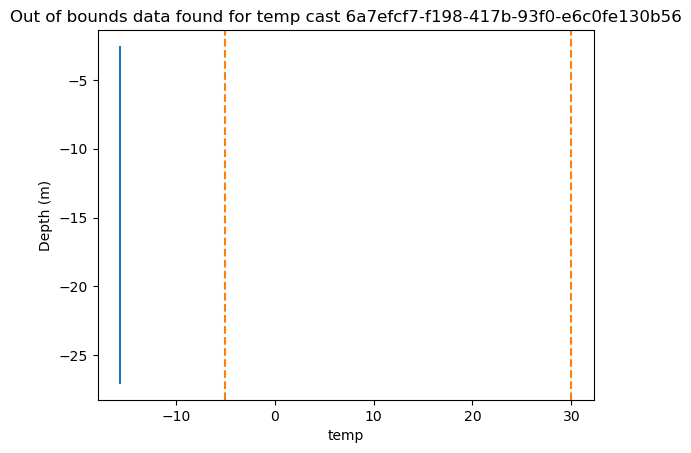

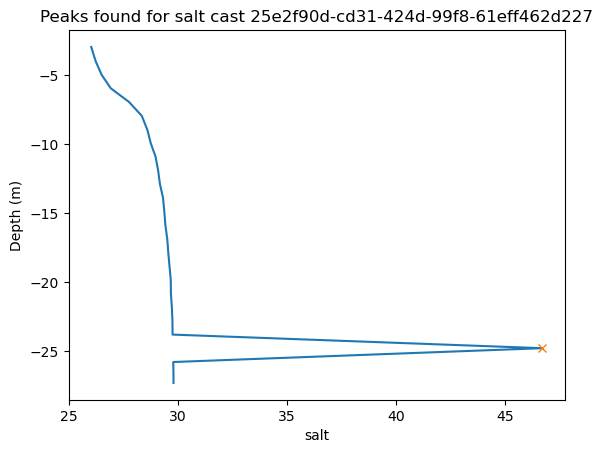

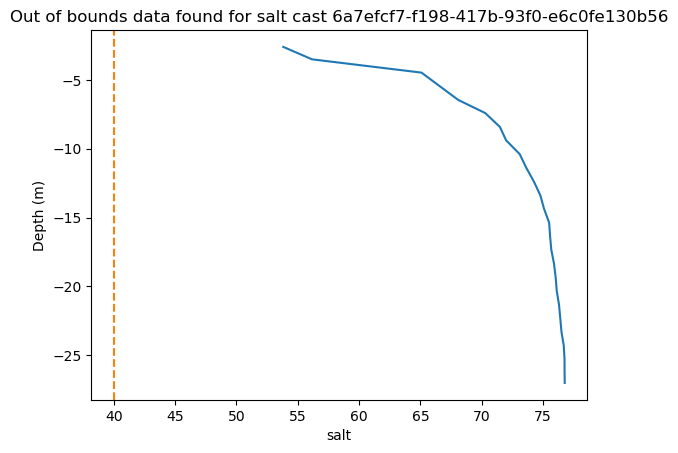

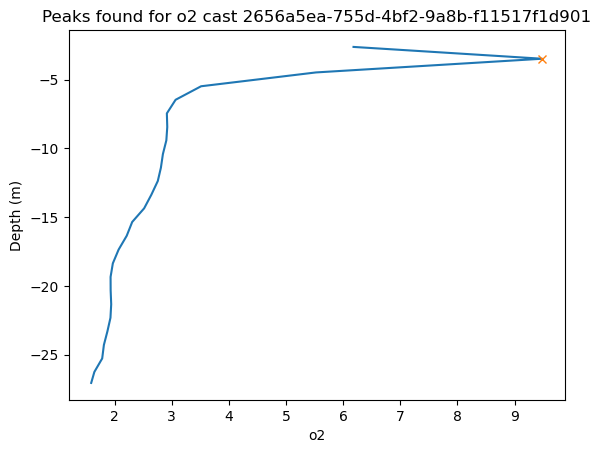

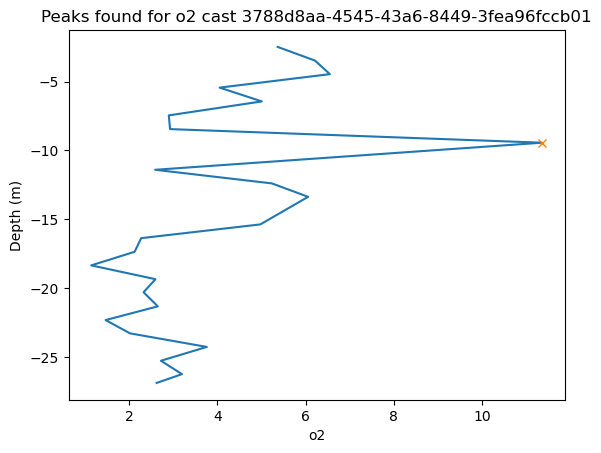

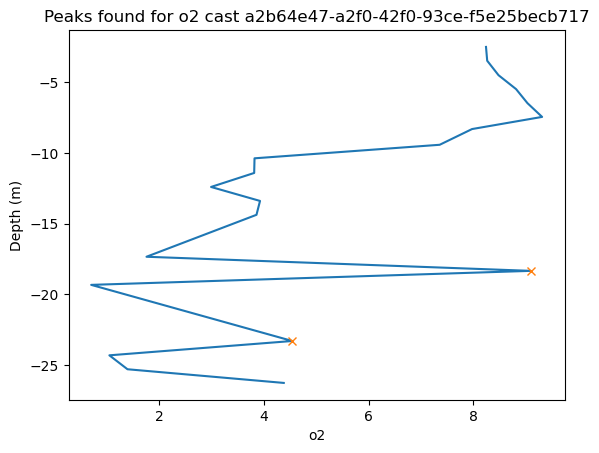

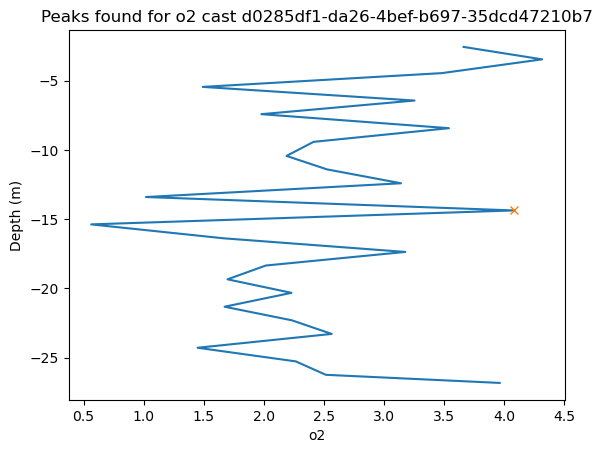

In [6]:
def extract_nwem(f, debug=False, con=None):
    if con is None:
        con = thread_con
    base = os.path.basename(f)
    # Parse the buoy ID from the filename
    location_id = np.vectorize(lambda s: base.startswith(s + '_'))(
        station_gdf.index.values).nonzero()[0]
    if len(location_id) != 1:
        print(f'Could not find location for file {f}')
        return
    location_id = station_gdf.index[location_id[0]]

    if not base.startswith(f'{location_id}_CTD'):
        # Skip this file, it's a different format (like pH)
        return

    matdata = loadmat(f)
    # Arrays are two-dimensional, with axis 0 corresponding to pressure bins
    # and axis 1 corresponding to cast.
    shape = matdata['Btime'].shape
    days = matdata['Btime'].flatten('F')
    df = pd.DataFrame({
        "datetime": pd.Timestamp('1999-12-31').tz_localize(-8*3600) + pd.to_timedelta(days, unit='D'),
        "depth": matdata['Bdepth'].flatten('F')
    })
    df['location_id'] = location_id
    df['source_id'] = nwem_source_id
    # Assign cast id's based on source array shape. Generate one UUID per cast,
    # then repeat it for the number of pressure levels
    df['cast_id'] = np.repeat([uuid.uuid4() for c in range(shape[1])], shape[0])
    data = {
        'temp': matdata['Btemp'].flatten('F'),
        'salt': matdata['Bsal'].flatten('F'),
        'o2': matdata['Boxy_mgL'].flatten('F'),
        'chla': matdata['Bfluor'].flatten('F')#,
        # Nitrate data is all over the place, not reliable
        #'no3': matdata['Bnitrate'].flatten('F')
    }

    for p,d in data.items():
        df['value'] = d
        df['parameter_id'] = p
        pruned = df.loc[~df.duplicated(subset=('datetime','depth','location_id','parameter_id','value')) &
            (df['value'] != -555)].dropna()
        for c,group in pruned.groupby('cast_id'):
            peaks = find_peaks(group['value'], threshold=outlier_thresholds[p],
                               width=(0,1))
            if len(peaks[0]) > 0:
                if debug:
                    fig, ax = plt.subplots()
                    ax.plot(group['value'], -group['depth'])
                    ax.plot(group['value'].iloc[peaks[0]], -group['depth'].iloc[peaks[0]], 'x')
                    ax.set(title=f'Peaks found for {p} cast {c}', ylabel='Depth (m)', xlabel=p)
                for pk in peaks[0]:
                    pruned = pruned.loc[(pruned['depth'] != group['depth'].iloc[pk]) &
                                        (pruned['cast_id'] != c)]
                data_nopeaks = group.reset_index().drop(peaks[0])
            else:
                data_nopeaks = group
            if p in limits and (limits[p][0] is not None and np.any(data_nopeaks['value'] < limits[p][0])
                                or limits[p][1] is not None and np.any(data_nopeaks['value'] > limits[p][1])):
                if debug:
                    fig, ax = plt.subplots()
                    ax.plot(data_nopeaks['value'], -data_nopeaks['depth'])
                    if limits[p][0] is not None:
                        ax.axvline(limits[p][0], linestyle='--', color='tab:orange')
                    if limits[p][1] is not None:
                        ax.axvline(limits[p][1], linestyle='--', color='tab:orange')
                    ax.set(title=f'Out of bounds data found for {p} cast {c}', ylabel='Depth (m)', xlabel=p)
                # Remove this entire cast
                pruned = pruned.loc[pruned['cast_id'] != c]
        if debug:
            display(f'{len(pruned)} rows for parameter {p}')
            if len(pruned):
                display(pruned.head())
        else:
            pruned.to_sql('observations', con=con, schema='obsdata', index=False, if_exists='append')

extract_nwem(glob.glob(nwem_files)[0], debug=True, con=engine)

In [7]:
with Pool(initializer=db_init) as p:
    p.map(extract_nwem, glob.glob(nwem_files))

/home/benr/mambaforge/envs/puget_sound_obs_data/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
